In [18]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [19]:
# read in dataset
dset = pd.read_csv('K - 2016_11_9.txt',sep = ' ') # read in dataset

In [20]:
#Variables
f=10

print("Sampling rate: " + str(f) + "Hz")
print(str(dset.shape[0]) + " Data points")
print(str(dset.shape[0]/(f*60)) + " Minutes")

Sampling rate: 10Hz
56783 Data points
94.63833333333334 Minutes


In [21]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
#d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
#d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
#d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
#d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 31.89 minutes
Autonomic light: 51.8616666667 minutes
Normal breathing: 9.69333333333 minutes
Cardio: 0.291666666667 minutes
Total: 93.7366666667 minutes


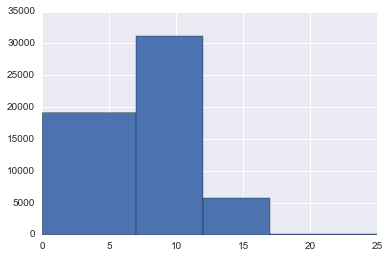

In [22]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/(60*f)
b2=n[1]/(60*f)
b3=n[2]/(60*f)
b4=n[3]/(60*f)

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print("Total: " + str(b1+b2+b3+b4) + " minutes")

In [23]:
f=d

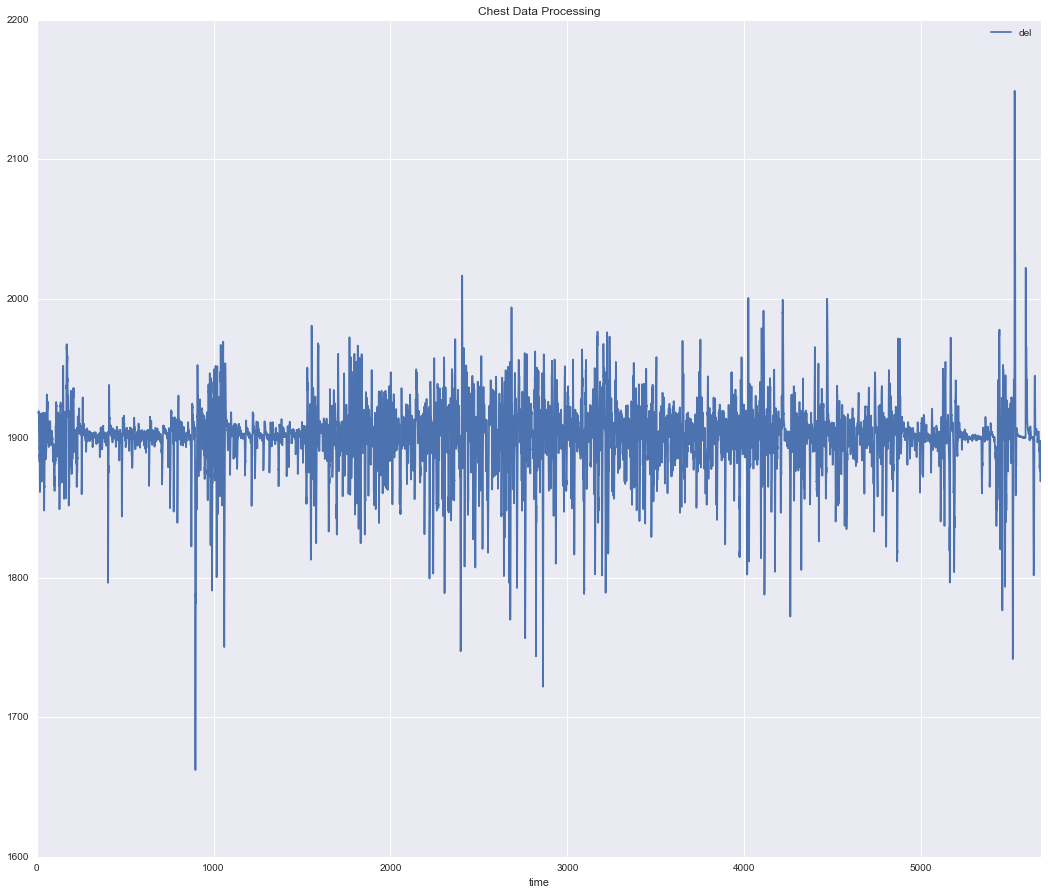

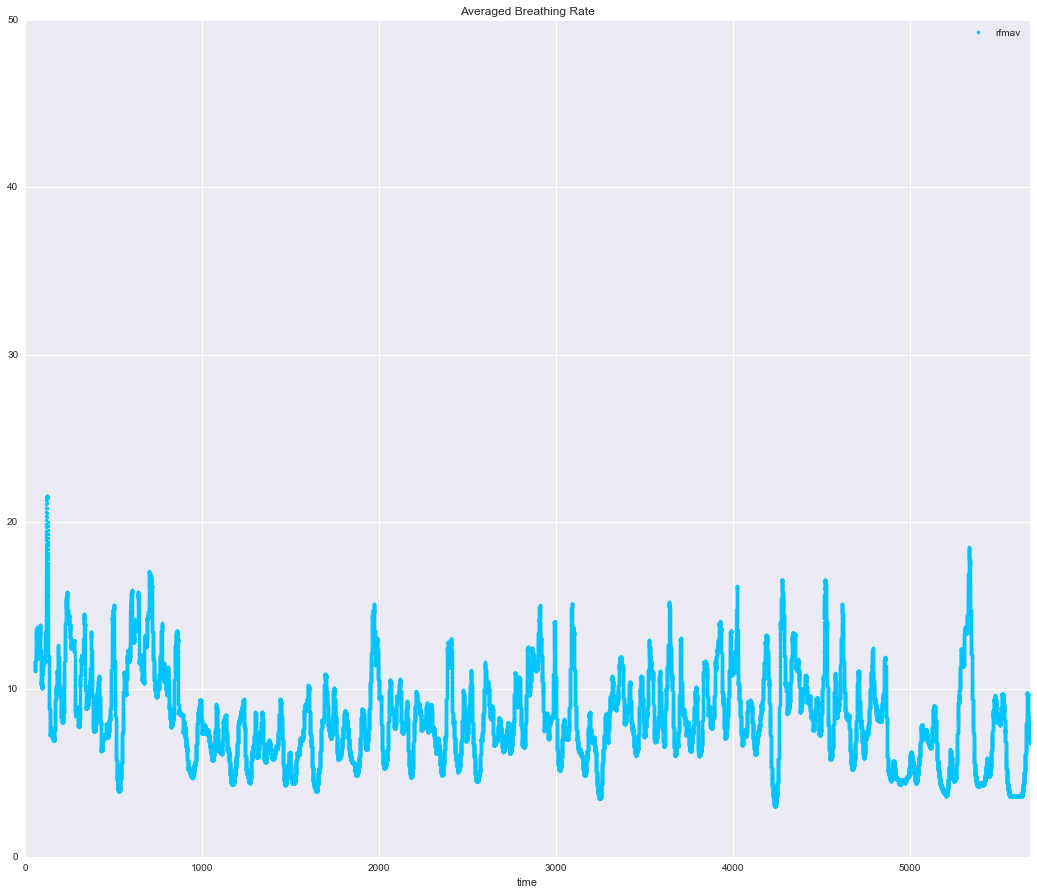

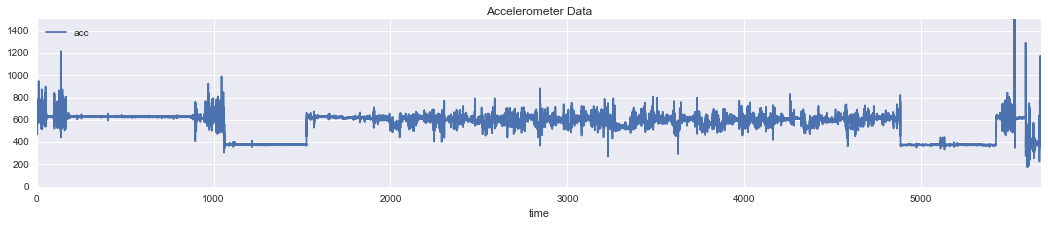

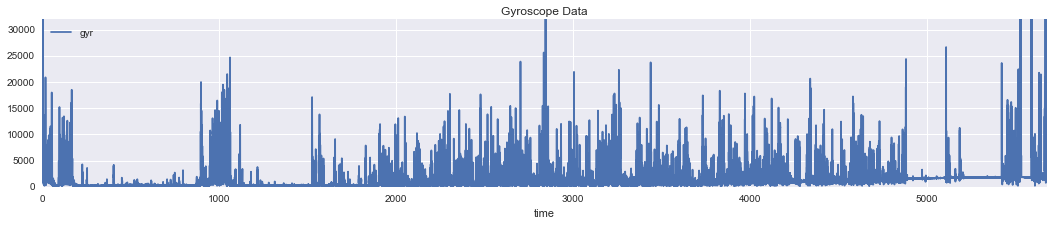

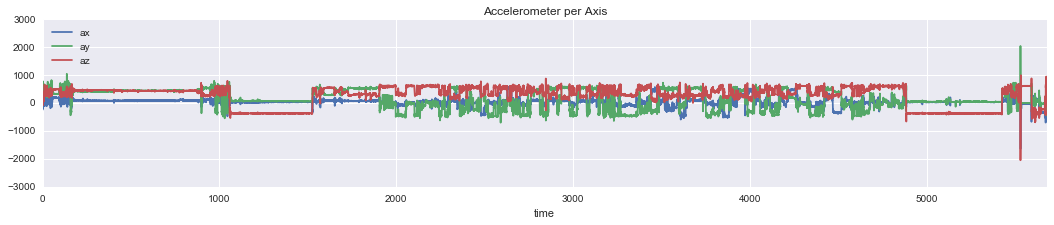

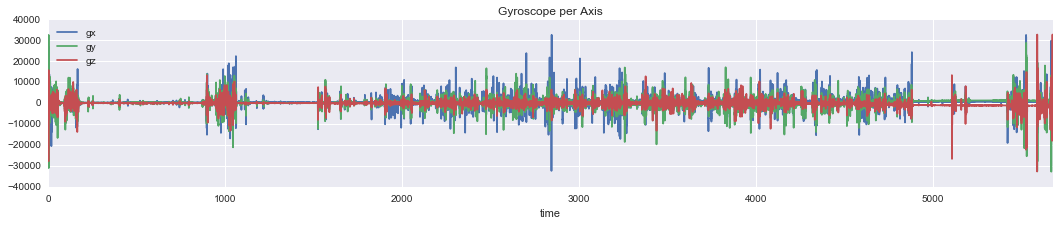

In [24]:
# this is just for plotting data 
g = d
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
#g['b2'] = 1600
#g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [25]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   2786   3082 -240  547  111 -1482 -2477  1075     0.0  ...    
1000    1000   2693   3017   56  515  316 -1761 -7766 -3779   100.0  ...    
2000    2000   2807   3220   99  424  455   146    79     8   200.0  ...    
3000    3000   2919   3247   87  412  470   171   104   -13   300.0  ...    
4000    4000   2932   3250   79  415  464   137   114   -17   400.0  ...    
5000    5000   2907   3231   91  433  446   251    80   -28   500.0  ...    
6000    6000   2941   3259   96  435  440   233     2    16   600.0  ...    
7000    7000   2962   3264   92  440  440   227   132    -6   700.0  ...    
8000    8000   2889   3247   96  435  441   186    99    36   800.0  ...    
9000    9000   2494   2873  111  518  399  2417 -8594 -4181   900.0  ...    
10000  10000   2585   2963   95  519  321  -762  -903  -614  1000.0  ...    
11000  11000   2654   2868   31   76 -369   176   105   -17  1100.0  ...    

In [26]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,rbtime,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1
0,0,2786,3082,-240,547,111,-1482,-2477,1075,0.0,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,607.560697,3080.174995,1900
1,1,2786,3082,-207,545,123,3052,417,8756,0.1,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,595.821282,9282.032590,1900
2,2,2785,3086,-121,551,159,14091,11200,2090,0.2,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,586.108352,18120.827271,1900
3,3,2786,3084,-136,448,36,-9647,-16322,1621,0.3,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,469.570016,19028.923616,1900
4,4,2784,3086,-148,577,127,-6286,-7734,3231,0.4,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,609.066499,10477.018326,1900
5,5,2780,3086,-113,576,150,-403,-3286,8656,0.5,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,605.842389,9267.499177,1900
6,6,2772,3087,-40,595,158,4239,5659,4341,0.6,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,616.918957,8296.847775,1900
7,7,2772,3086,-9,600,131,978,2899,2837,0.7,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,614.200293,4172.439814,1900
8,8,2766,3087,3,584,107,-2794,5478,2707,0.8,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,593.728894,6718.836879,1900
9,9,2767,3084,35,556,112,-8505,3331,4029,0.9,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,568.247305,9983.157166,1900
